In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import vaex

import numpy as np
import math
from scipy.stats import truncnorm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import random as python_random

In [2]:
# Plot standard settings
sns.set_theme()
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['legend.title_fontsize'] = 18
mpl.rcParams['legend.fontsize'] = 14

# 01 - Preprocessing

In [13]:
# Loading the train dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Checking size and initial features
print(train_data.shape)
print(test_data.shape)
display(train_data.head())
test_data.head()

(900000, 33)
(700000, 32)


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,...,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,...,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,...,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
3,900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,...,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
4,900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,...,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


In [14]:
# Dropping id column
train_data = train_data.drop(columns='id')

# Splitting features and target value
x_train = train_data.drop(columns='target')
x_test = test_data.drop(columns='id')
y_train = train_data[['target']]

# Checking features' characteristics
print(x_train.info())
x_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    900000 non-null  float64
 1   f_01    900000 non-null  float64
 2   f_02    900000 non-null  float64
 3   f_03    900000 non-null  float64
 4   f_04    900000 non-null  float64
 5   f_05    900000 non-null  float64
 6   f_06    900000 non-null  float64
 7   f_07    900000 non-null  int64  
 8   f_08    900000 non-null  int64  
 9   f_09    900000 non-null  int64  
 10  f_10    900000 non-null  int64  
 11  f_11    900000 non-null  int64  
 12  f_12    900000 non-null  int64  
 13  f_13    900000 non-null  int64  
 14  f_14    900000 non-null  int64  
 15  f_15    900000 non-null  int64  
 16  f_16    900000 non-null  int64  
 17  f_17    900000 non-null  int64  
 18  f_18    900000 non-null  int64  
 19  f_19    900000 non-null  float64
 20  f_20    900000 non-null  float64
 21  f_21    90

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,...,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,-0.000286,0.001165,0.001174,-0.001368,-0.000571,0.000284,-0.000709,2.031460,2.057998,2.362431,...,-0.178730,-0.156307,-0.009273,-0.369459,-0.342738,0.176549,0.357591,-0.380876,0.345661,1.002654
std,0.998888,0.999193,1.000514,1.000175,1.000167,0.999875,0.999942,1.656172,1.590955,1.637706,...,2.400494,2.484706,2.450797,2.453405,2.386941,2.416959,2.476020,238.773054,0.475584,0.818989
min,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,0.000000,...,-11.257917,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000
25%,-0.675490,-0.675162,-0.674369,-0.676114,-0.675909,-0.673437,-0.674876,1.000000,1.000000,1.000000,...,-1.804612,-1.820063,-1.645585,-2.019739,-1.955956,-1.440424,-1.261598,-159.427418,0.000000,0.000000
50%,0.001144,0.002014,0.002218,-0.002227,-0.001662,-0.000438,-0.001492,2.000000,2.000000,2.000000,...,-0.190571,-0.152668,0.030850,-0.390966,-0.340746,0.160912,0.404212,-0.519808,0.000000,1.000000
75%,0.674337,0.675021,0.677505,0.672544,0.673789,0.675028,0.674749,3.000000,3.000000,3.000000,...,1.444508,1.507071,1.661676,1.255408,1.266673,1.795928,2.028219,158.987357,1.000000,2.000000
max,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,14.000000,...,11.475325,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000


## Dealing with feature 27

In [15]:
 def mod_feature_27(dataset):
    
    print('Modifiying {data}')
    # Unique values at every row for feature 27
    f_27_unique_count = dataset.f_27.apply(lambda x: len(set(x)))
    f_27_unique_count = f_27_unique_count.to_frame(name='unique_count')
    
    # Splitting the 10 letters into different columns
    f_27_split = []
    
    # Building dataframe of split characters
    for i in range(0, 10):
        f_27_split.append(dataset.f_27.str[i:i+1])
        
    f_27_split = pd.DataFrame(np.array(f_27_split).T)
    f_27_split.columns = ['l'+str(i) for i in range(0,10)]
    display(f_27_split.head(2))
    
    # Assigning every letter to an integer
    letter_lst = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
     'S', 'T']
    num_lst = list(range(0, len(letter_lst)))
    
    # Replacing values on dataframe made by splitting feature 27
    map_dict = {letter: num for letter, num in zip(letter_lst, num_lst)}
    f_27_split = f_27_split.replace(map_dict)
    display(f_27_split.head(2))
    
    # Concat converted letters with count of unique letters
    f_27 = pd.concat([f_27_split, f_27_unique_count], axis=1)
    
    # Concat back with train set and drop starting feature27
    modified_dataset = dataset.drop(columns='f_27')
    modified_dataset = pd.concat([modified_dataset, f_27], axis=1)

    return modified_dataset

In [ ]:
x_train = mod_feature_27(x_train)
x_test = mod_feature_27(x_test)

# 02 - Defining the model

In [28]:
global EPOCHS, LR, BATCH_SIZE
EPOCHS = 100
#LR = 0.088996
BATCH_SIZE = 1024

def make_model(input_num, 
               nn1=128, nn2=128, nn3=64, nn4=16, nn5=8, 
               lr=0.088996, l2_fac=1e-5,
               dense_kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
               dense_bias_initializer='zeros'
              ):
    
    # Model layers
    inputs = keras.Input(shape=(input_num,))
    x = keras.layers.Dense(nn1, activation='swish', kernel_regularizer=keras.regularizers.l2(l2_fac), 
                           kernel_initializer=dense_kernel_initializer, bias_initializer=dense_bias_initializer)(inputs)
    #x = keras.layers.Dropout(0.10)(x)
    x = keras.layers.Dense(nn2, activation='swish', kernel_regularizer=keras.regularizers.l2(l2_fac), 
                           kernel_initializer=dense_kernel_initializer,
                           bias_initializer=dense_bias_initializer)(x)
    x = keras.layers.Dense(nn3, activation='swish', kernel_regularizer=keras.regularizers.l2(l2_fac), 
                           kernel_initializer=dense_kernel_initializer, 
                           bias_initializer=dense_bias_initializer)(x)
    x = keras.layers.Dense(nn4, activation='swish', kernel_regularizer=keras.regularizers.l2(l2_fac), 
                           kernel_initializer=dense_kernel_initializer,
                           bias_initializer=dense_bias_initializer)(x)
    x = keras.layers.Dense(nn5, activation='swish', kernel_regularizer=keras.regularizers.l2(l2_fac), 
                           kernel_initializer=dense_kernel_initializer, 
                           bias_initializer=dense_bias_initializer)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    # Model instance
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Compiling
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        metrics=['AUC'],
        loss=keras.losses.BinaryCrossentropy()
    )
    
    return model


def fit_model(model, train_feat, train_targ, val_data=None):
    
    # Setting callbacks for the fitting method
    cbks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=3, restore_best_weights=True, mode='min'),
        #keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.80)
    ]
    # Fitting
    hist = model.fit(train_feat, train_targ, 
        epochs=EPOCHS, 
        #callbacks=cbks, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        validation_data=val_data, 
        verbose='auto'
    )

    return hist

# 03. Hyperparameter Tuning

In [118]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', KerasClassifier(model=make_model, input_num=x_train.shape[1],
              nn1=128, nn2=64, nn3=32, nn4=16, nn5=8,
              l2_fac=1e-5, lr=0.05))
])

parameter_space = {
    'estimator__input_num': [x_train.shape[1]],
    'estimator__nn1': [128, 256], 
    'estimator__nn2': [64, 128], 
    'estimator__nn3': [64], 
    'estimator__nn4': [16, 32],
    #'estimator__batch_size': [512, 1024, 2048],
    'estimator__lr': truncnorm(0.005, 0.100)
}

random_search = RandomizedSearchCV(
    pipe, parameter_space, n_iter=32, cv=KFold(n_splits=5), scoring='roc_auc', verbose=0
)
random_search.fit(x_train, y_train)

88/88 [==============================] - 1s 7ms/step


352/352 [==============================] - 6s 14ms/step - loss: 0.2615 - auc: 0.9604


879/879 [==============================] - 12s 12ms/step - loss: 0.2257 - auc: 0.9715


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('estimator',
                                              KerasClassifier(input_num=41, l2_fac=1e-05, learning_rate=0.05, model=<function make_model at 0x000001C19D0F59D0>, nn1=128, nn2=64, nn3=32, nn4=16, nn5=8))]),
                   n_iter=48,
                   param_distributions={'estimator__batch_size': [512, 1024,
                                                                  2048],
                                        'estimator__input_num': [41],
                                        'estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C1A1E06E50>,
                                        'estimator__nn1': [128, 256],
                                        'estimator__nn2': [64, 128],
                                        'estimator__nn3': [64],
                                        'estimator__nn4': [16, 32]},
                   scoring='roc_auc')

In [122]:
results = pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__batch_size,param_estimator__input_num,param_estimator__learning_rate,param_estimator__nn1,param_estimator__nn2,param_estimator__nn3,param_estimator__nn4,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,8.601857,0.399329,1.066876,0.069167,1024,41,0.088244,128,128,64,32,"{'estimator__batch_size': 1024, 'estimator__in...",0.986347,0.986234,0.986458,0.986748,0.986929,0.986543,0.000258,1
22,10.843700,2.644173,1.233583,0.116558,1024,41,0.047674,256,128,64,16,"{'estimator__batch_size': 1024, 'estimator__in...",0.986919,0.985822,0.986246,0.986209,0.986426,0.986324,0.000356,2
12,9.811187,0.475638,1.142660,0.026991,1024,41,0.063725,256,128,64,16,"{'estimator__batch_size': 1024, 'estimator__in...",0.986049,0.986337,0.985628,0.986069,0.986485,0.986113,0.000293,3
14,10.203431,0.391828,1.148524,0.058136,2048,41,0.098549,256,128,64,32,"{'estimator__batch_size': 2048, 'estimator__in...",0.985705,0.985806,0.985843,0.986247,0.986681,0.986056,0.000363,4
19,10.680193,2.414315,1.229268,0.106115,1024,41,0.052032,256,128,64,32,"{'estimator__batch_size': 1024, 'estimator__in...",0.985380,0.986140,0.987184,0.985625,0.985875,0.986041,0.000625,5


In [123]:
# Pandas series with dicts in every row
params = []

# Setting up a dataframe with only the parameters stored in results.params dictionary; keeps the sorting
params.extend([list(dict_values.values()) for dict_values in results.params.values])
params_df = pd.DataFrame(params, columns=results.params.values[0].keys())
params_df

,estimator__batch_size,estimator__input_num,estimator__learning_rate,estimator__nn1,estimator__nn2,estimator__nn3,estimator__nn4
0,1024,41,0.088244,128,128,64,32
1,1024,41,0.047674,256,128,64,16
2,1024,41,0.063725,256,128,64,16
3,2048,41,0.098549,256,128,64,32
4,1024,41,0.052032,256,128,64,32
5,2048,41,0.008613,128,128,64,32
6,512,41,0.024536,256,64,64,32
7,2048,41,0.059048,256,128,64,32
8,1024,41,0.087917,256,128,64,16
9,512,41,0.008052,256,128,64,32


# 04. Cross-validation

In [53]:
def cross_val(x_train, y_train, n_splits=10):

    # Generating folds for cross validation
    folds = KFold(n_splits=n_splits).split(x_train)
    
    # Iterable to keep track of histories and scores
    histories = []
    scores = []
    
    # Cross validation: iterating over train and validation indexes
    for fold, (tr_id, val_id) in enumerate(folds):
        
        # Assign train and validation sets based on said indexes and instantiate, fit and transform a scaler
        # for train and validation sets' data points separately
        x_tr = StandardScaler().fit_transform(x_train.iloc[tr_id, :])
        y_tr = y_train.iloc[tr_id, :]
        x_val = StandardScaler().fit_transform(x_train.iloc[val_id, :])
        y_val = y_train.iloc[val_id, :]
        
        # Assigining exponential decay learning rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.085, decay_steps=1200, decay_rate=0.85
        )
        # Make model
        model = make_model(x_tr.shape[1], l2_fac=1e-5, lr=lr_schedule)
        
        # Compile and fit --> save into history list
        history = fit_model(model, x_tr, y_tr, val_data=(x_val, y_val))
        histories.append(history.history)
        # Keep track of model scores throughout cross validation
        y_val_pred = model.predict(x_val, verbose=0)
        scores.append(roc_auc_score(y_val, y_val_pred))
        
        # Plot losses
        plt.figure()
        sns.lineplot(x=range(len(histories[-1]['val_loss'])), y=histories[-1]['val_loss'], 
                     linewidth=3, label='Validation Loss')
        sns.lineplot(x=range(len(histories[-1]['val_loss'])), y=histories[-1]['loss'], 
                     linewidth=3, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss with epoch for fold number {fold+1}')
        plt.show()
    
    return scores, history
        

Epoch 1/100
792/792 [==============================] - 7s 8ms/step - loss: 1.1625 - auc: 0.8807 - val_loss: 0.3752 - val_auc: 0.9557
Epoch 2/100
792/792 [==============================] - 6s 7ms/step - loss: 0.3150 - auc: 0.9676 - val_loss: 0.2924 - val_auc: 0.9710
Epoch 3/100
792/792 [==============================] - 5s 7ms/step - loss: 0.2531 - auc: 0.9782 - val_loss: 0.2625 - val_auc: 0.9744
Epoch 4/100
792/792 [==============================] - 6s 7ms/step - loss: 0.2281 - auc: 0.9814 - val_loss: 0.2053 - val_auc: 0.9849
Epoch 5/100
792/792 [==============================] - 6s 7ms/step - loss: 0.1914 - auc: 0.9867 - val_loss: 0.1922 - val_auc: 0.9871
Epoch 6/100
792/792 [==============================] - 6s 7ms/step - loss: 0.1760 - auc: 0.9885 - val_loss: 0.1835 - val_auc: 0.9873
Epoch 7/100
792/792 [==============================] - 6s 7ms/step - loss: 0.1671 - auc: 0.9895 - val_loss: 0.1652 - val_auc: 0.9899
Epoch 8/100
792/792 [==============================] - 6s 7ms/step - 

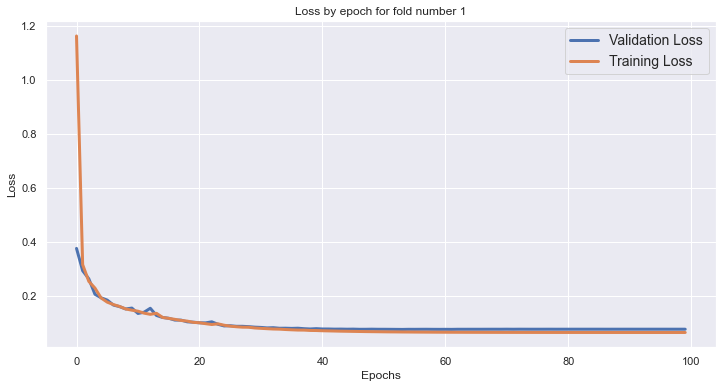

Epoch 1/100
792/792 [==============================] - 6s 7ms/step - loss: 1.2515 - auc: 0.4987 - val_loss: 0.7892 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7722 - auc: 0.5000 - val_loss: 0.7570 - val_auc: 0.5000
Epoch 3/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7455 - auc: 0.5000 - val_loss: 0.7348 - val_auc: 0.5000
Epoch 4/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7299 - auc: 0.4997 - val_loss: 0.7255 - val_auc: 0.5000
Epoch 5/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7178 - auc: 0.4996 - val_loss: 0.7119 - val_auc: 0.5000
Epoch 6/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7081 - auc: 0.5001 - val_loss: 0.7064 - val_auc: 0.5000
Epoch 7/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7028 - auc: 0.5014 - val_loss: 0.7011 - val_auc: 0.5004
Epoch 8/100
792/792 [==============================] - 5s 7ms/step - 

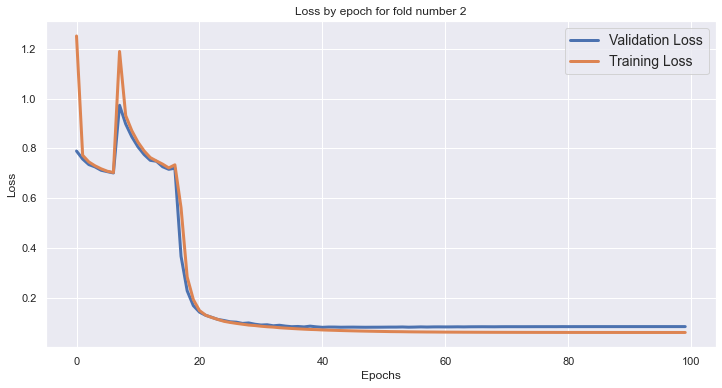

Epoch 1/100
792/792 [==============================] - 6s 7ms/step - loss: 1.2742 - auc: 0.4991 - val_loss: 0.8056 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7900 - auc: 0.5004 - val_loss: 0.7749 - val_auc: 0.5000
Epoch 3/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7695 - auc: 0.5002 - val_loss: 0.7511 - val_auc: 0.5000
Epoch 4/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7415 - auc: 0.4996 - val_loss: 0.7328 - val_auc: 0.5000
Epoch 5/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7311 - auc: 0.4994 - val_loss: 0.7242 - val_auc: 0.5000
Epoch 6/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7181 - auc: 0.4999 - val_loss: 0.7126 - val_auc: 0.5000
Epoch 7/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7099 - auc: 0.5001 - val_loss: 0.7061 - val_auc: 0.5000
Epoch 8/100
792/792 [==============================] - 5s 7ms/step - 

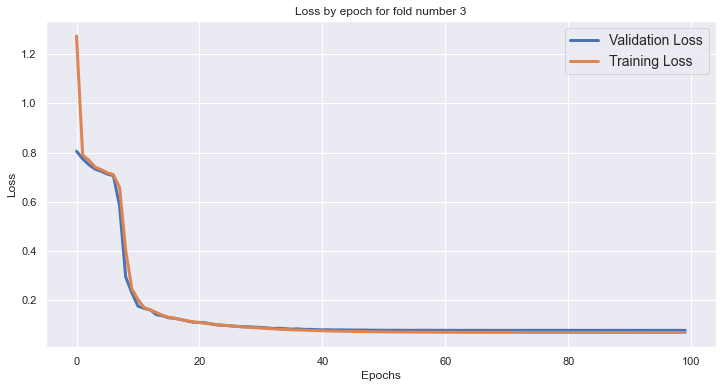

Epoch 1/100
792/792 [==============================] - 6s 7ms/step - loss: 1.2819 - auc: 0.5000 - val_loss: 0.8051 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7902 - auc: 0.5007 - val_loss: 0.7763 - val_auc: 0.5000
Epoch 3/100
792/792 [==============================] - 5s 7ms/step - loss: 1.0908 - auc: 0.5001 - val_loss: 0.8387 - val_auc: 0.5000
Epoch 4/100
792/792 [==============================] - 5s 7ms/step - loss: 0.8155 - auc: 0.5003 - val_loss: 0.7947 - val_auc: 0.4998
Epoch 5/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7782 - auc: 0.5001 - val_loss: 0.7633 - val_auc: 0.4998
Epoch 6/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7517 - auc: 0.5006 - val_loss: 0.7416 - val_auc: 0.4999
Epoch 7/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7629 - auc: 0.5007 - val_loss: 0.7652 - val_auc: 0.5001
Epoch 8/100
792/792 [==============================] - 5s 7ms/step - 

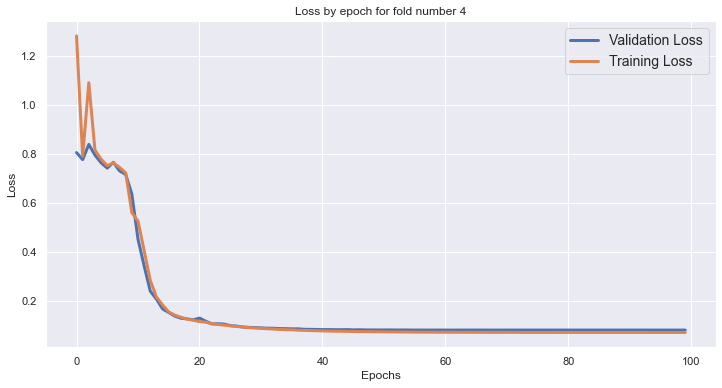

Epoch 1/100
792/792 [==============================] - 8s 8ms/step - loss: 1.3465 - auc: 0.5000 - val_loss: 0.7909 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 7s 8ms/step - loss: 0.7733 - auc: 0.4997 - val_loss: 0.7594 - val_auc: 0.5000
Epoch 3/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7466 - auc: 0.5006 - val_loss: 0.7370 - val_auc: 0.5000
Epoch 4/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7305 - auc: 0.4997 - val_loss: 0.7216 - val_auc: 0.5010
Epoch 5/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7533 - auc: 0.5487 - val_loss: 0.7587 - val_auc: 0.5480
Epoch 6/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7489 - auc: 0.5565 - val_loss: 0.7338 - val_auc: 0.5562
Epoch 7/100
792/792 [==============================] - 6s 8ms/step - loss: 0.8004 - auc: 0.6409 - val_loss: 0.6983 - val_auc: 0.6650
Epoch 8/100
792/792 [==============================] - 6s 8ms/step - 

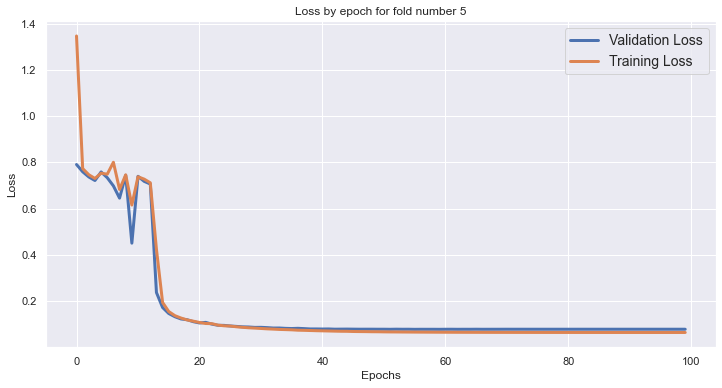

Epoch 1/100
792/792 [==============================] - 7s 8ms/step - loss: 1.1369 - auc: 0.8404 - val_loss: 0.3938 - val_auc: 0.9469
Epoch 2/100
792/792 [==============================] - 7s 8ms/step - loss: 0.3357 - auc: 0.9601 - val_loss: 0.2951 - val_auc: 0.9704
Epoch 3/100
792/792 [==============================] - 6s 8ms/step - loss: 0.2615 - auc: 0.9752 - val_loss: 0.2352 - val_auc: 0.9800
Epoch 4/100
792/792 [==============================] - 6s 8ms/step - loss: 0.2229 - auc: 0.9812 - val_loss: 0.2223 - val_auc: 0.9821
Epoch 5/100
792/792 [==============================] - 6s 8ms/step - loss: 0.1982 - auc: 0.9848 - val_loss: 0.1929 - val_auc: 0.9855
Epoch 6/100
792/792 [==============================] - 6s 8ms/step - loss: 0.1838 - auc: 0.9869 - val_loss: 0.1988 - val_auc: 0.9843
Epoch 7/100
792/792 [==============================] - 6s 8ms/step - loss: 0.1848 - auc: 0.9869 - val_loss: 0.1772 - val_auc: 0.9890
Epoch 8/100
792/792 [==============================] - 6s 8ms/step - 

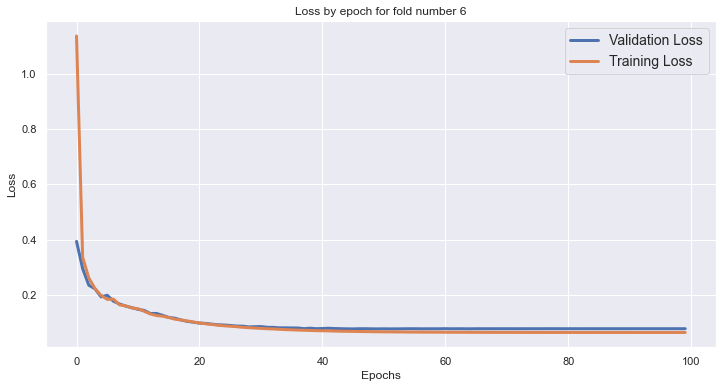

Epoch 1/100
792/792 [==============================] - 8s 8ms/step - loss: 0.9884 - auc: 0.5003 - val_loss: 0.7849 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7653 - auc: 0.5000 - val_loss: 0.7485 - val_auc: 0.5000
Epoch 3/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7365 - auc: 0.4992 - val_loss: 0.7260 - val_auc: 0.5000
Epoch 4/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7188 - auc: 0.4990 - val_loss: 0.7134 - val_auc: 0.4999
Epoch 5/100
792/792 [==============================] - 6s 8ms/step - loss: 0.5582 - auc: 0.7831 - val_loss: 0.3435 - val_auc: 0.9516
Epoch 6/100
792/792 [==============================] - 6s 8ms/step - loss: 0.2553 - auc: 0.9705 - val_loss: 0.2249 - val_auc: 0.9778
Epoch 7/100
792/792 [==============================] - 6s 8ms/step - loss: 0.2021 - auc: 0.9823 - val_loss: 0.2016 - val_auc: 0.9851
Epoch 8/100
792/792 [==============================] - 6s 8ms/step - 

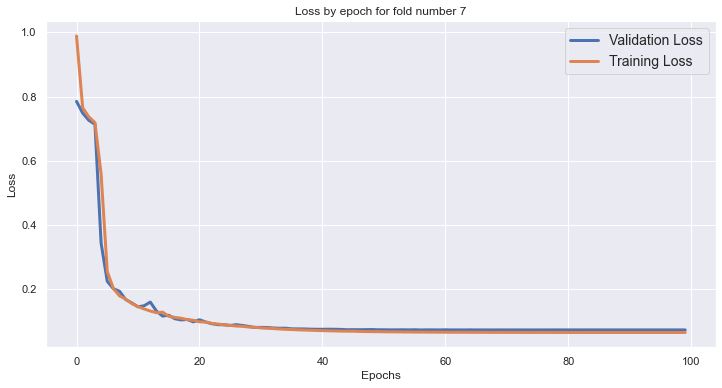

Epoch 1/100
792/792 [==============================] - 7s 8ms/step - loss: 1.5849 - auc: 0.5015 - val_loss: 0.7840 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7688 - auc: 0.5006 - val_loss: 0.7558 - val_auc: 0.5000
Epoch 3/100
792/792 [==============================] - 6s 7ms/step - loss: 0.7373 - auc: 0.5265 - val_loss: 0.5022 - val_auc: 0.8622
Epoch 4/100
792/792 [==============================] - 6s 7ms/step - loss: 0.3531 - auc: 0.9430 - val_loss: 0.3211 - val_auc: 0.9621
Epoch 5/100
792/792 [==============================] - 6s 7ms/step - loss: 0.2501 - auc: 0.9745 - val_loss: 0.2671 - val_auc: 0.9697
Epoch 6/100
792/792 [==============================] - 6s 7ms/step - loss: 0.2161 - auc: 0.9816 - val_loss: 0.2939 - val_auc: 0.9733
Epoch 7/100
792/792 [==============================] - 6s 7ms/step - loss: 0.1954 - auc: 0.9852 - val_loss: 0.1755 - val_auc: 0.9882
Epoch 8/100
792/792 [==============================] - 6s 7ms/step - 

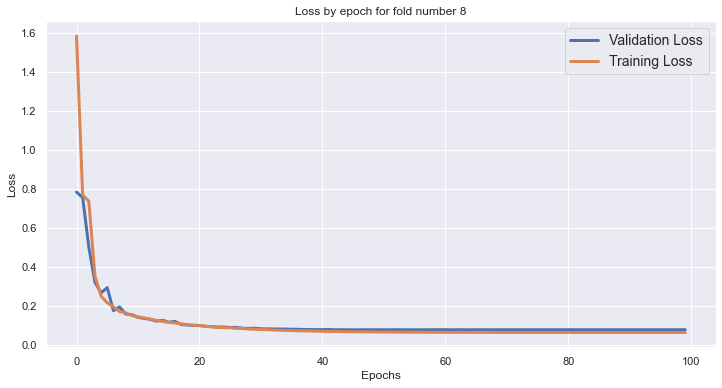

Epoch 1/100
792/792 [==============================] - 7s 8ms/step - loss: 1.0514 - auc: 0.5018 - val_loss: 0.7654 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 6s 8ms/step - loss: 0.7460 - auc: 0.4987 - val_loss: 0.7301 - val_auc: 0.4999
Epoch 3/100
792/792 [==============================] - 6s 7ms/step - loss: 0.4802 - auc: 0.8529 - val_loss: 0.3482 - val_auc: 0.9636
Epoch 4/100
792/792 [==============================] - 6s 7ms/step - loss: 0.2342 - auc: 0.9767 - val_loss: 0.2091 - val_auc: 0.9823
Epoch 5/100
792/792 [==============================] - 6s 7ms/step - loss: 0.1908 - auc: 0.9853 - val_loss: 0.1930 - val_auc: 0.9863
Epoch 6/100
792/792 [==============================] - 5s 7ms/step - loss: 0.1867 - auc: 0.9864 - val_loss: 0.1683 - val_auc: 0.9891
Epoch 7/100
792/792 [==============================] - 6s 7ms/step - loss: 0.1658 - auc: 0.9894 - val_loss: 0.1703 - val_auc: 0.9888
Epoch 8/100
792/792 [==============================] - 6s 7ms/step - 

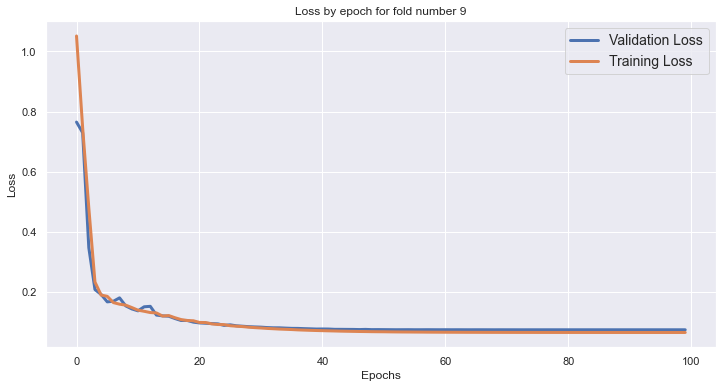

Epoch 1/100
792/792 [==============================] - 7s 8ms/step - loss: 1.4792 - auc: 0.5002 - val_loss: 0.7935 - val_auc: 0.5000
Epoch 2/100
792/792 [==============================] - 6s 7ms/step - loss: 0.7769 - auc: 0.5007 - val_loss: 0.7621 - val_auc: 0.5000
Epoch 3/100
792/792 [==============================] - 6s 7ms/step - loss: 0.7935 - auc: 0.5590 - val_loss: 0.7455 - val_auc: 0.5995
Epoch 4/100
792/792 [==============================] - 6s 7ms/step - loss: 0.7485 - auc: 0.6272 - val_loss: 0.7539 - val_auc: 0.6159
Epoch 5/100
792/792 [==============================] - 6s 7ms/step - loss: 0.7651 - auc: 0.5076 - val_loss: 0.7446 - val_auc: 0.5000
Epoch 6/100
792/792 [==============================] - 5s 7ms/step - loss: 0.7295 - auc: 0.4993 - val_loss: 0.7180 - val_auc: 0.5001
Epoch 7/100
792/792 [==============================] - 6s 7ms/step - loss: 0.7113 - auc: 0.5028 - val_loss: 0.7048 - val_auc: 0.5581
Epoch 8/100
792/792 [==============================] - 5s 7ms/step - 

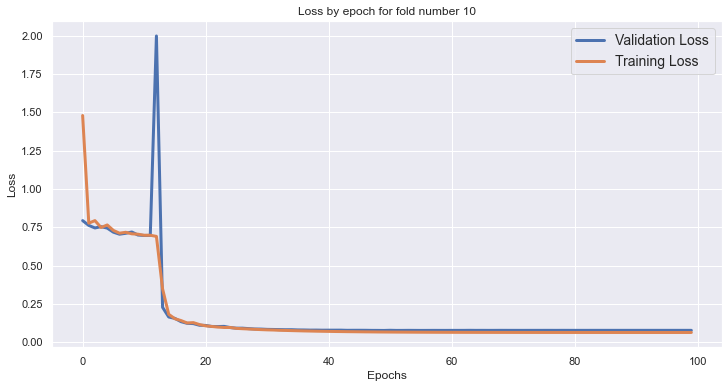

In [54]:
scores, history = cross_val(x_train, y_train)

In [55]:
print(f'{np.mean(scores)*100:.2f}%.')

99.75%.


# 05. Submission

In [29]:
def predict(seed=333):
    
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)
    
    predictions = []
    
    # Scaling datasets
    x_train_norm = StandardScaler().fit_transform(x_train)
    x_test_norm = StandardScaler().fit_transform(x_test)
    
    # Remaking the compiled model
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.085, decay_steps=1200, decay_rate=0.85
    )
    model_sub = make_model(x_train_norm.shape[1], l2_fac=1e-5, lr=lr_schedule)
    # Fitting
    hist = fit_model(model_sub, x_train_norm, y_train)
    # Scoring
    scores = model_sub.predict(x_test_norm)
    
    predictions.append(scores)
    
    return predictions

In [34]:
# To store predictions
prediction_lst = []

for seed in range(1, 10+1):
    # Generate predictions
    prediction_lst = predict()
    print('/n'*10)

Epoch 1/100
879/879 [==============================] - 6s 6ms/step - loss: 2.3568 - auc: 0.8643
Epoch 2/100
879/879 [==============================] - 7s 7ms/step - loss: 0.3881 - auc: 0.9480
Epoch 3/100
879/879 [==============================] - 6s 7ms/step - loss: 0.3013 - auc: 0.9701
Epoch 4/100
879/879 [==============================] - 5s 6ms/step - loss: 0.2436 - auc: 0.9805
Epoch 5/100
879/879 [==============================] - 5s 6ms/step - loss: 0.2132 - auc: 0.9843
Epoch 6/100
879/879 [==============================] - 5s 6ms/step - loss: 0.1903 - auc: 0.9868
Epoch 7/100
879/879 [==============================] - 5s 6ms/step - loss: 0.1741 - auc: 0.9884
Epoch 8/100
879/879 [==============================] - 5s 6ms/step - loss: 0.1619 - auc: 0.9897
Epoch 9/100
879/879 [==============================] - 5s 6ms/step - loss: 0.1524 - auc: 0.9908
Epoch 10/100
879/879 [==============================] - 6s 7ms/step - loss: 0.1431 - auc: 0.9919
Epoch 11/100
879/879 [=================

879/879 [==============================] - 5s 6ms/step - loss: 0.0631 - auc: 0.9982
Epoch 86/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0631 - auc: 0.9982
Epoch 87/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0631 - auc: 0.9982
Epoch 88/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 89/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0630 - auc: 0.9982
Epoch 90/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 91/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 92/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0630 - auc: 0.9982
Epoch 93/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 94/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0630 - auc: 0.9982
Epoch 95/100
879/879 [=====================

879/879 [==============================] - 5s 5ms/step - loss: 0.0632 - auc: 0.9982
Epoch 70/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0632 - auc: 0.9982
Epoch 71/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0632 - auc: 0.9982
Epoch 72/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0632 - auc: 0.9982
Epoch 73/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0631 - auc: 0.9982
Epoch 74/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0631 - auc: 0.9982
Epoch 75/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0631 - auc: 0.9982
Epoch 76/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0631 - auc: 0.9982
Epoch 77/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0631 - auc: 0.9982
Epoch 78/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0631 - auc: 0.9982
Epoch 79/100
879/879 [=====================

879/879 [==============================] - 5s 6ms/step - loss: 0.0641 - auc: 0.9982
Epoch 54/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0640 - auc: 0.9982
Epoch 55/100
879/879 [==============================] - 6s 6ms/step - loss: 0.0639 - auc: 0.9982
Epoch 56/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0638 - auc: 0.9982
Epoch 57/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0637 - auc: 0.9982
Epoch 58/100
879/879 [==============================] - 6s 6ms/step - loss: 0.0637 - auc: 0.9982
Epoch 59/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0636 - auc: 0.9982
Epoch 60/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0635 - auc: 0.9982
Epoch 61/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0635 - auc: 0.9982
Epoch 62/100
879/879 [==============================] - 6s 6ms/step - loss: 0.0634 - auc: 0.9982
Epoch 63/100
879/879 [=====================

879/879 [==============================] - 4s 5ms/step - loss: 0.0692 - auc: 0.9979
Epoch 38/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0686 - auc: 0.9979
Epoch 39/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0680 - auc: 0.9980
Epoch 40/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0675 - auc: 0.9980
Epoch 41/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0671 - auc: 0.9980
Epoch 42/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0667 - auc: 0.9980
Epoch 43/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0663 - auc: 0.9980
Epoch 44/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0660 - auc: 0.9981
Epoch 45/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0657 - auc: 0.9981
Epoch 46/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0654 - auc: 0.9981
Epoch 47/100
879/879 [=====================

879/879 [==============================] - 4s 5ms/step - loss: 0.0915 - auc: 0.9964
Epoch 22/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0890 - auc: 0.9966
Epoch 23/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0867 - auc: 0.9968
Epoch 24/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0847 - auc: 0.9969
Epoch 25/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0827 - auc: 0.9970
Epoch 26/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0810 - auc: 0.9972
Epoch 27/100
879/879 [==============================] - 4s 5ms/step - loss: 0.0794 - auc: 0.9973
Epoch 28/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0779 - auc: 0.9974
Epoch 29/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0767 - auc: 0.9974
Epoch 30/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0754 - auc: 0.9975
Epoch 31/100
879/879 [=====================

Epoch 5/100
879/879 [==============================] - 5s 5ms/step - loss: 0.2132 - auc: 0.9843
Epoch 6/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1903 - auc: 0.9868
Epoch 7/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1741 - auc: 0.9884
Epoch 8/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1619 - auc: 0.9897
Epoch 9/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1524 - auc: 0.9908
Epoch 10/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1431 - auc: 0.9919
Epoch 11/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1370 - auc: 0.9925
Epoch 12/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1301 - auc: 0.9933
Epoch 13/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1236 - auc: 0.9939
Epoch 14/100
879/879 [==============================] - 5s 5ms/step - loss: 0.1181 - auc: 0.9944
Epoch 15/100
879/879 [=============

879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 90/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 91/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 92/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 93/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 94/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 95/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 96/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 97/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 98/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0630 - auc: 0.9982
Epoch 99/100
879/879 [=====================

879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 74/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 75/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 76/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 77/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 78/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 79/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 80/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 81/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 82/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0631 - auc: 0.9982
Epoch 83/100
879/879 [=====================

879/879 [==============================] - 6s 6ms/step - loss: 0.0637 - auc: 0.9982
Epoch 58/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0637 - auc: 0.9982
Epoch 59/100
879/879 [==============================] - 6s 6ms/step - loss: 0.0636 - auc: 0.9982
Epoch 60/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0635 - auc: 0.9982
Epoch 61/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0635 - auc: 0.9982
Epoch 62/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0634 - auc: 0.9982
Epoch 63/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0634 - auc: 0.9982
Epoch 64/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0634 - auc: 0.9982
Epoch 65/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0633 - auc: 0.9982
Epoch 66/100
879/879 [==============================] - 6s 6ms/step - loss: 0.0633 - auc: 0.9982
Epoch 67/100
879/879 [=====================

879/879 [==============================] - 5s 6ms/step - loss: 0.0671 - auc: 0.9980
Epoch 42/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0667 - auc: 0.9980
Epoch 43/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0663 - auc: 0.9980
Epoch 44/100
879/879 [==============================] - 5s 5ms/step - loss: 0.0660 - auc: 0.9981
Epoch 45/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0657 - auc: 0.9981
Epoch 46/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0654 - auc: 0.9981
Epoch 47/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0652 - auc: 0.9981
Epoch 48/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0650 - auc: 0.9981
Epoch 49/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0648 - auc: 0.9981
Epoch 50/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0646 - auc: 0.9981
Epoch 51/100
879/879 [=====================

Epoch 25/100
879/879 [==============================] - 7s 8ms/step - loss: 0.0827 - auc: 0.9970
Epoch 26/100
879/879 [==============================] - 7s 8ms/step - loss: 0.0810 - auc: 0.9972
Epoch 27/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0794 - auc: 0.9973
Epoch 28/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0779 - auc: 0.9974
Epoch 29/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0767 - auc: 0.9974
Epoch 30/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0754 - auc: 0.9975
Epoch 31/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0743 - auc: 0.9976
Epoch 32/100
879/879 [==============================] - 7s 7ms/step - loss: 0.0732 - auc: 0.9977
Epoch 33/100
879/879 [==============================] - 6s 7ms/step - loss: 0.0723 - auc: 0.9977
Epoch 34/100
879/879 [==============================] - 5s 6ms/step - loss: 0.0714 - auc: 0.9978
Epoch 35/100
879/879 [========

In [41]:
# Set up submission dataframe
submission = test_data[['id']].copy()
submission['target'] = np.array(predictions).mean(axis=0)
# Export to csv
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,target
0,900000,9.999989e-01
1,900001,9.999915e-01
2,900002,5.689741e-11
3,900003,1.329391e-05
4,900004,9.998564e-01
5,900005,9.507300e-03
6,900006,1.784458e-01
7,900007,9.999976e-01
8,900008,2.207130e-06
9,900009,9.999899e-01
